In [34]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


# Preprocess image (resize, normalize)
IMG_SIZE = (256, 256)
NUM_CLASSES = 21 # 20 classes + the background

# Transformation class
class VOCTransforms:
    def __init__(self, img_size, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        self.transform = transforms.Compose([
            transforms.Resize(img_size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True),
            transforms.Normalize(mean=mean, std=std),
        ])
        self.target_transform = transforms.Compose([
            transforms.Resize(img_size, interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToImage(),
            transforms.ToDtype(torch.long, scale=False),
        ])
    def __call__(self, img, target):
        image = self.transform(img)
        target = self.target_transform(target)
        target = target.squeeze(0)
        return image, target

# Load dataset, image and segmentation mask

voc_transforms = VOCTransforms(IMG_SIZE)

DATA_ROOT = '/Users/ianyoo/Documents/School/ECS 171/Final Project/subject-isolation/data'

train_dataset = VOCSegmentation(
    root=DATA_ROOT,
    year='2012',
    image_set='train',
    download=False,
    transforms=voc_transforms
)

val_dataset = VOCSegmentation(
    root=DATA_ROOT,
    year='2012',
    image_set='val',
    download=False,
    transforms=voc_transforms
)

BATCH_SIZE = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

# Had to set num_workers to 0 for VOCTransforms parallel error

In [35]:
# Helper function for double convolution
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels), # Add batch normalization
            nn.ReLU(inplace=True),
            # Second convolution
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

# Downscaling with maxpool then double convolution
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

# Upscaling then double conv
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear use normal convolutions to reduce channel num
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels + out_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1) # Concatenate along channel dimension (SKIP CONNECTION)
        return self.conv(x)

# Final layer class to map to output classes (21)
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Define U-Net model:
class UNET(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNET, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Encoder path (downsampling):
            # conv -> relu -> conv -> relu -> maxpool
            # repeat, doubling channels
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor) # Bottom of the U

        # Decoder path (upsampling):
            # upsample -> concat with encoder feature map -> convs
            # repeat, halving channels
        # Note: In 'Up', in_channels is the sum from skip + upsample
        if bilinear: # will depend on the factor applied above
            self.up1 = Up(512, 512, bilinear)
            self.up2 = Up(512, 256, bilinear)
            self.up3 = Up(256, 128, bilinear)
            self.up4 = Up(128, 64, bilinear) 
        else:
            self.up1 = Up(1024, 512, bilinear)
            self.up2 = Up(512, 256, bilinear)
            self.up3 = Up(256, 128, bilinear)
            self.up4 = Up(128, 64, bilinear)

        
        # Final 1x1 conv -> class scores for each pixel
        self.outc = OutConv(64, n_classes)

    def forward(self, x): # flow of input
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3) 
        x = self.up3(x, x2) 
        x = self.up4(x, x1) 
        logits = self.outc(x)
        return logits

In [36]:
# Use trained model to predict segmentation masks
if torch.backends.mps.is_available():
    device = torch.device('mps')
# Fallback to CPU
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

model = UNET(n_channels=3, n_classes=NUM_CLASSES).to(device)
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
criterion = nn.CrossEntropyLoss(ignore_index=255) # loss func
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

print("Train start")
for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f}")

# Save the final model
torch.save(model.state_dict(), 'unet_voc_final.pth')

Using device: mps
Train start
Epoch 1/50 | Train Loss: 2.4057 | Val Loss: 2.1563
Epoch 2/50 | Train Loss: 1.8789 | Val Loss: 2.3898
Epoch 3/50 | Train Loss: 1.5709 | Val Loss: 1.6665
Epoch 4/50 | Train Loss: 1.3679 | Val Loss: 1.3564
Epoch 5/50 | Train Loss: 1.2504 | Val Loss: 1.2858
Epoch 6/50 | Train Loss: 1.1817 | Val Loss: 1.1975
Epoch 7/50 | Train Loss: 1.1408 | Val Loss: 1.1615
Epoch 8/50 | Train Loss: 1.1043 | Val Loss: 1.0979
Epoch 9/50 | Train Loss: 1.0765 | Val Loss: 1.0842
Epoch 10/50 | Train Loss: 1.0482 | Val Loss: 1.0283
Epoch 11/50 | Train Loss: 1.0223 | Val Loss: 1.0227
Epoch 12/50 | Train Loss: 1.0059 | Val Loss: 1.0232
Epoch 13/50 | Train Loss: 0.9876 | Val Loss: 1.0269
Epoch 14/50 | Train Loss: 0.9656 | Val Loss: 1.0233
Epoch 15/50 | Train Loss: 0.9550 | Val Loss: 0.9612
Epoch 16/50 | Train Loss: 0.9339 | Val Loss: 0.9721
Epoch 17/50 | Train Loss: 0.9206 | Val Loss: 0.9385
Epoch 18/50 | Train Loss: 0.8930 | Val Loss: 0.9397
Epoch 19/50 | Train Loss: 0.8732 | Val Loss

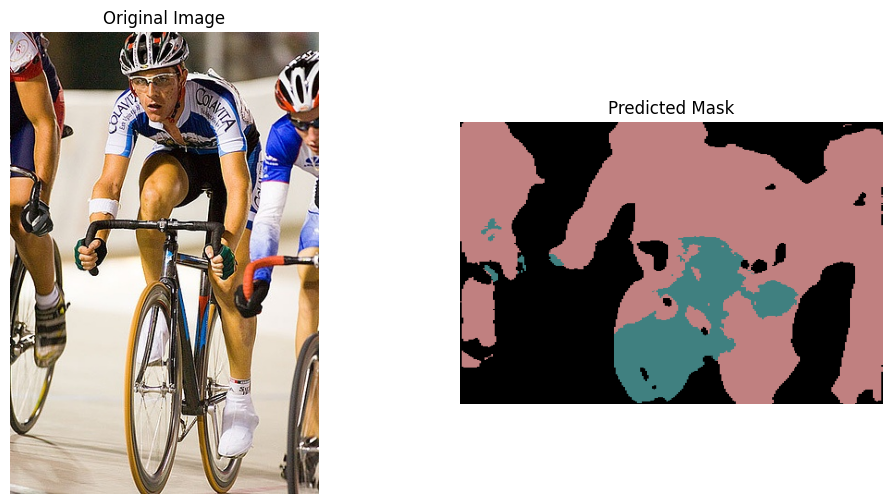

In [37]:
def predict_and_visualize(model, image_path, device, transforms_func, num_classes):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    original_size = image.size[::-1] # H, W

    # Use only the image transform part for prediction
    input_tensor = transforms_func.transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)

    # Get the prediction (class with highest score)
    pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Resize mask back to original image size
    pred_mask_pil = Image.fromarray(pred_mask.astype(np.uint8)).resize(original_size, Image.NEAREST)

    # Create a colormap for visualization (PASCAL VOC standard)
    def create_pascal_label_colormap():
        colormap = np.zeros((256, 3), dtype=int)
        ind = np.arange(256, dtype=int)
        for shift in reversed(range(8)):
            for channel in range(3):
                colormap[:, channel] |= ((ind >> channel) & 1) << shift
            ind >>= 3
        return colormap

    colormap = create_pascal_label_colormap()
    colored_mask = colormap[pred_mask_pil]

    # Display
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(colored_mask.astype(np.uint8))
    plt.axis('off')
    plt.show()

# --- Example Prediction ---
# Load your trained model (if not already loaded)
# model.load_state_dict(torch.load('unet_voc_final.pth'))
# model.to(device)

# Choose an image from your validation set or a new one
# (Make sure to get the path correctly)
try:
    image_path, _ = val_dataset.images[4], val_dataset.masks[4] # Example path
    predict_and_visualize(model, image_path, device, voc_transforms, NUM_CLASSES)
except Exception as e:
     print(f"Could not load image for prediction: {e}")
     print("Please provide a valid image path.")